## Replicating of "It's alright, John" by Smith and Dorling (1996) in the BMJ

#### Date: February, 2024

#### Notebook by: [crahal](https://www.github.com\crahal)

**Abstract:** This is work replicates '“I'm all right, John": voting patterns and mortality in England and Wales, 1981–92' by George Davey Smith and Daniel Dorling in the BMJ in 1996 (in advance of the 1997 election of Tony Blair). The primary motivation -- as per [Philip Clarke's](https://www.ndph.ox.ac.uk/team/philip-clarke) idea -- is to see if anything substantially changed in terms of patterns between voteshare of major parties and health outcomes. A link to that original paper can be found [here](https://www.bmj.com/content/313/7072/1573), and with a couple of other useful contextual things in the BMJ [here](https://www.bmj.com/content/340/bmj.c3294) and [here](https://www.bmj.com/content/384/bmj.q538).

### Section 0: Preamble

First, lets load a few custom helper functions which we need throughout this exercise:

In [1]:
from helpers import make_merged,\
                    make_summary_tables,\
                    make_merged_2024,\
                    make_df_gpd_census,\
                    make_sii, make_hid,\
                    plot_scatters,\
                    plot_bivariate_choropleth_map_census,\
                    plot_over_time,\
                    make_temporal_printouts,\
                    check_constituency_numbers,\
                    print_mean_ASMRs

Next, we want to download our 2019 General Election voting data from [here](https://researchbriefings.files.parliament.uk/documents/CBP-8749/HoC-GE2019-results-by-constituency.xlsx) and put it somewhere like `./data/raw/voting/`. Do the same for the 2024 election, which can be found [HEREHEREHEREHERE](). We next want to download our deprivation data from [here](https://commonslibrary.parliament.uk/constituency-data-indices-of-deprivation/), and put that somewhere like `./data/raw/deprivation/`. Next, download the mortality data from [here](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/1961numbersandagestandardisedmortalityratesforprematuredeathsbyparliamentaryconstituencyandsexin2021), and put that somewhere like `./data/raw/mortality/`. For the 2024 Election linkage to the ASMR data, we need this constituency lookup table from [HEREHEREHERE](). We use data from the 2021 Census for Health and Disability. See [here](https://www.ons.gov.uk/filters/a0f00cf4-2654-4168-825b-c0fb0b8c228b/dimensions/change?f=selections#dimensions--added). A few notes about all this data:

* We only examine constituencies in England (because a lot of the data comes from NHS England, or the cross-tabbed data is only available for England). 
* There were, accordingly, 533 constituencies in the 2019 General Election, and 543 in 2024. Note, However, that one constituency returned the Speaker of the House of Commons for each of the two elections. This is subsequently dropped (see below).
* There are reasons why -- for the 2024 ASMR analysis -- we are not able to link all 543 constituencies (explained and described below).
* Edit: we no longer analyse this deprivation data, because it is only avaialble for 2019 (and we have subsequently extended this to 2024 analysis:
    * We primarily use two indicies of deprivation: Health deprivation and disability, and the Index of Multiple Deprivation. There is a House of Commons Library briefing paper on this [here](https://commonslibrary.parliament.uk/research-briefings/cbp-7327/).
    * For correlations using deprivation data, we use [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) for consistency because the indices of deprivation come in the form of ordinal 'deprivation ranks' (which only show how deprived an area is relative to other areas in England).
* While it changes none of the other analysis, it is kept into the 2019_asmr dataframe just in case this linkage is of use to other researchers in the future.
* The mortality data is at the level of rates per 100,000 population, standardised to the 2013 European Standard Population (this allows comparison between populations which may contain different proportions of people of different ages).
* While we use data on two different elections (which directly get correlated with vote share), our other variables are fixed for the year of 2021 (i.e., ASMR and census data).
* Our shapefiles for the choropleth maps comes from the [Westminster Parliamentary Constituencies (December 2019)](https://www.data.gov.uk/dataset/53f92606-da07-4432-bc20-98518c079f6f/westminster-parliamentary-constituencies-december-2019-boundaries-uk-bgc) and [here](https://geoportal.statistics.gov.uk/datasets/ons::westminster-parliamentary-constituencies-july-2024-names-and-codes-in-the-uk-v2/about) for 2019 and 2024 respectively. Boundary files are provided by the Office for National Statistics.

### Section 1.: ASMR Analysis

#### Section 1.1 Data Wrangling

Next, lets merge all these datasets together on the individual constituencies with left merges onto the voting data as an index. Note: this is a little bit complicated, because we need to use the interim deprivation file to merge the `ONSConstID` and `ConstituencyName` with `Parliamentary Constituency` from the ASMR data to be able to merge the constituency names onto the ASMR data.

In [2]:
df_2019 = make_merged(2019)

Note: dropping all constituencies thare are outside of England here.


In [3]:
df_2024 = make_merged_2024()

Number of new constituencies in lookup file:  519
Number of old constituencies in lookup file:  533
The length of our final 2024 dataframe is: 519
The 24 which get dropped saved to:
./data/derived/check_those_not_in_lookup.csv


Lets see how many raw rows of data we have that aren't null for the 'First party' field in the raw voting field. Note that we're expecting 533 and 534 consistent with the recent boundary changes (this is just an additional safety check as to whether the numbers match what comes out of the functions above.

In [4]:
df_2019 = df_2019[df_2019['First party'].notnull()]
df_2024 = df_2024[df_2024['First party'].notnull()]
print('Length of 2019 df after notnulling(); "First party":',
      len(df_2019))
print('Length of 2024 df after notnulling(); "First party":',
      len(df_2024))

Length of 2019 df after notnulling(); "First party": 533
Length of 2024 df after notnulling(); "First party": 519


Lets next double safety check that we've aligned the ASMR data correctly onto the voting files. Note that because of boundary changes, we have substantially fewer rows of the merged 2024 voting data (see above)

In [5]:
print('Length of 2019 df which has got ASMR_m data:',
      len(df_2019[df_2019['ASMR_m'].notnull()]))
print('Length of 2024 df which has got ASMR_m data:',
      len(df_2024[df_2024['ASMR_m'].notnull()]))

print('Length of 2019 df which has got ASMR_f data:',
      len(df_2019[df_2019['ASMR_f'].notnull()]))
print('Length of 2024 df which has got ASMR_f data:',
      len(df_2024[df_2024['ASMR_f'].notnull()]))

Length of 2019 df which has got ASMR_m data: 533
Length of 2024 df which has got ASMR_m data: 519
Length of 2019 df which has got ASMR_f data: 533
Length of 2024 df which has got ASMR_f data: 519


So, looks like we have all for 533 (great) for 2019, and 519 of the 2024 election (543 seats total). This is, importantly, for England, and not other parts of the UK. Next, lets print out ome mean ASMR data for the two different elecctions against three parties:

In [6]:
print_mean_ASMRs(df_2019, df_2024)

Labour mean ASMR for men in 2019:  554.107
Conservative mean ASMR for men in 2019:  413.534
Other party mean ASMR for men in 2019:  339.567
Labour mean ASMR for women in 2019:  345.703
Conservative mean ASMR for women in 2019:  264.861
Other party mean ASMR for women in 2019:  212.656
Labour mean ASMR for men in 2024:  504.04
Conservative mean ASMR for men in 2024:  374.806
Other party mean ASMR for men in 2024:  380.711
Labour mean ASMR for women in 2024:  319.975
Conservative mean ASMR for women in 2024:  238.713
Other party mean ASMR for women in 2024:  236.248


In [7]:
lab_wins_2019 = len(df_2019[df_2019['first_party_3']=='Lab'])
print('Labour wins in 2019:', lab_wins_2019)
con_wins_2019 = len(df_2019[df_2019['first_party_3']=='Con'])
print('Conservative wins in 2019: ', con_wins_2019)
lab_wins_2024 = len(df_2024[df_2024['first_party_3']=='Lab'])
print('Labour wins in 2024:', lab_wins_2024)
con_wins_2024 = len(df_2024[df_2024['first_party_3']=='Con'])
print('Conservative wins in 2019:', con_wins_2024)

Labour wins in 2019: 179
Conservative wins in 2019:  345
Labour wins in 2024: 339
Conservative wins in 2019: 107


Lets remove the speaker from both datasets, and check that the row length decrements by one:

In [8]:
df_2019 = df_2019[df_2019['First party']!='Spk']
df_2024 = df_2024[df_2024['First party']!='Spk']
print('Length of 2019 dataset after dropping speaker: ', len(df_2019))
print('Length of 2024 dataset after dropping speaker: ', len(df_2024))

Length of 2019 dataset after dropping speaker:  532
Length of 2024 dataset after dropping speaker:  518


Lets recap why we have 532 and 518. Having 532 is relatively self explanatory: There were 533 constituencies in England in 2019, and we can link them perfectly to the ASMR data. We drop one for speaker, where the vote shares are all 0.

But why 519 for 2024, when the number of constituencies in England actually (increased from 533 to 543)? Well, our lookup table only contains 519 new constituency names in the file. There are 24 that are not contained in it. After some manual examination, these are all entirely new constituencies, which are not the _preferred_ mapping from the old constituency name (from the 533) to one of the redrawn boundaries. Our choices here are really twofold:

1. Proceed with 519,
2. Attempt to manually reconcile the remaining 24, independently.

The first option probably seems a lot more safer than the second.

#### 1.2 Data Visualisation

Lets make our first visualisation and print out some accompanying summary statistics for each of the four correlations calculated, Note: there isn't really much point replicating these figures for other parties because all parties are actually -- in one way or another -- contained within (at least true for 2019, less true for 2024 due to constituency boundary\name changes).

The length of the 2019 data going into the scatters is:  532
The length of the 2024 data going into the scatters is:  518
2019: Labour Labour vote share vs ASMR (F) pearsons r: 0.6531, p-value 5.229569559113915e-66
2024: Labour vote share vs ASMR (F) pearsons r: 0.539, p-value 2.2584514062957535e-40
2019: Labour vote share vs ASMR (M) pearsons r: 0.708, p-value 3.5779487045039413e-82
2024: Labour vote share vs ASMR (M) pearsons r: 0.54, p-value 1.3976802734757177e-40


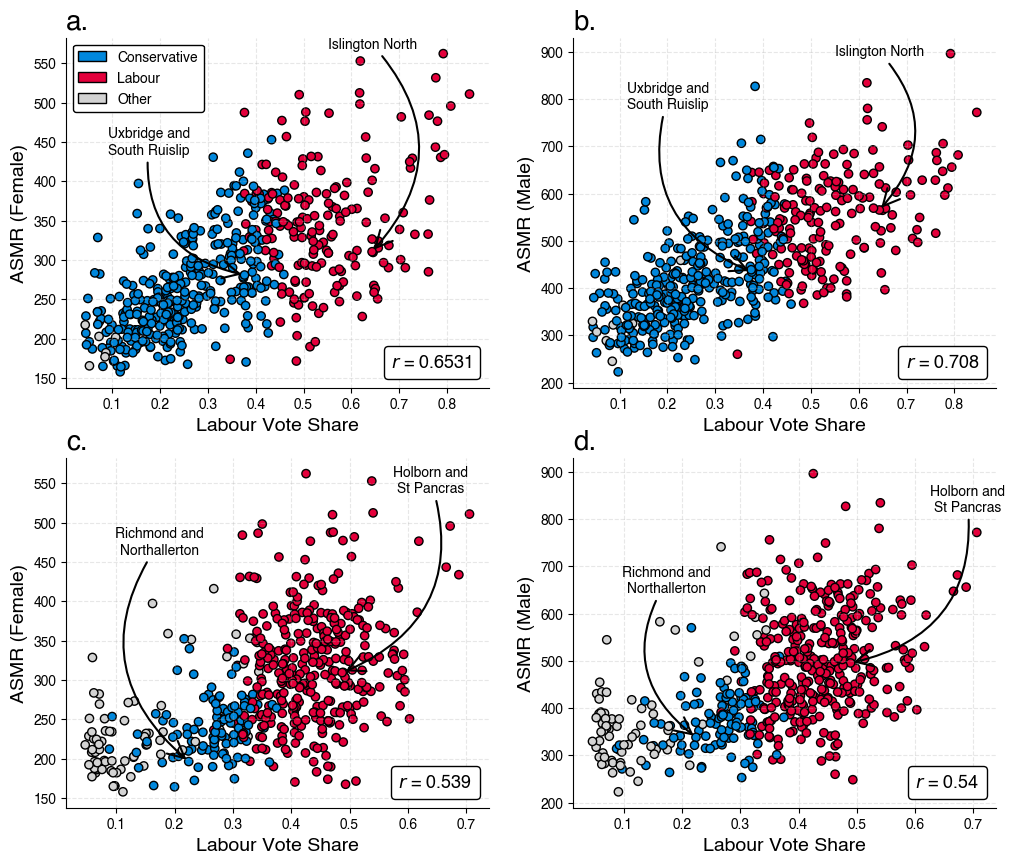

In [9]:
plot_scatters(df_2019, df_2024, ['Lab PC', 'Labour', True])

The length of the 2019 data going into the scatters is:  532
The length of the 2024 data going into the scatters is:  518
2019: Conservative Labour vote share vs ASMR (F) pearsons r: -0.4892, p-value 2.360258021215989e-33
2024: Conservative vote share vs ASMR (F) pearsons r: -0.602, p-value 2.129153870315073e-52
2019: Conservative vote share vs ASMR (M) pearsons r: -0.545, p-value 2.0769334672973714e-42
2024: Conservative vote share vs ASMR (M) pearsons r: 0.54, p-value 1.3976802734757177e-40


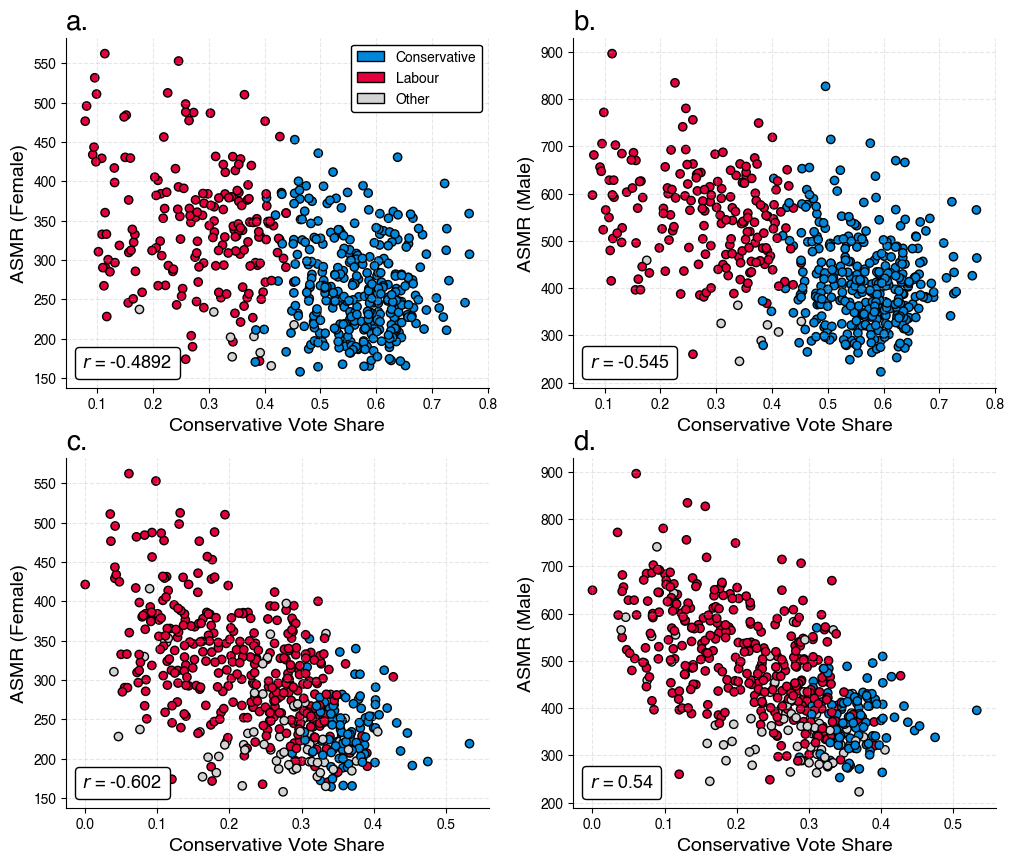

In [10]:
plot_scatters(df_2019, df_2024, ['Con PC', 'Conservative', False])

The length of the 2019 data going into the scatters is:  532
The length of the 2024 data going into the scatters is:  518
2019: Liberal Democrats Labour vote share vs ASMR (F) pearsons r: -0.5514, p-value 1.1843789654698608e-43
2024: Liberal Democrats vote share vs ASMR (F) pearsons r: -0.4932, p-value 4.11572307267373e-33
2019: Liberal Democrats vote share vs ASMR (M) pearsons r: -0.553, p-value 6.534968212779533e-44
2024: Liberal Democrats vote share vs ASMR (M) pearsons r: 0.54, p-value 1.3976802734757177e-40


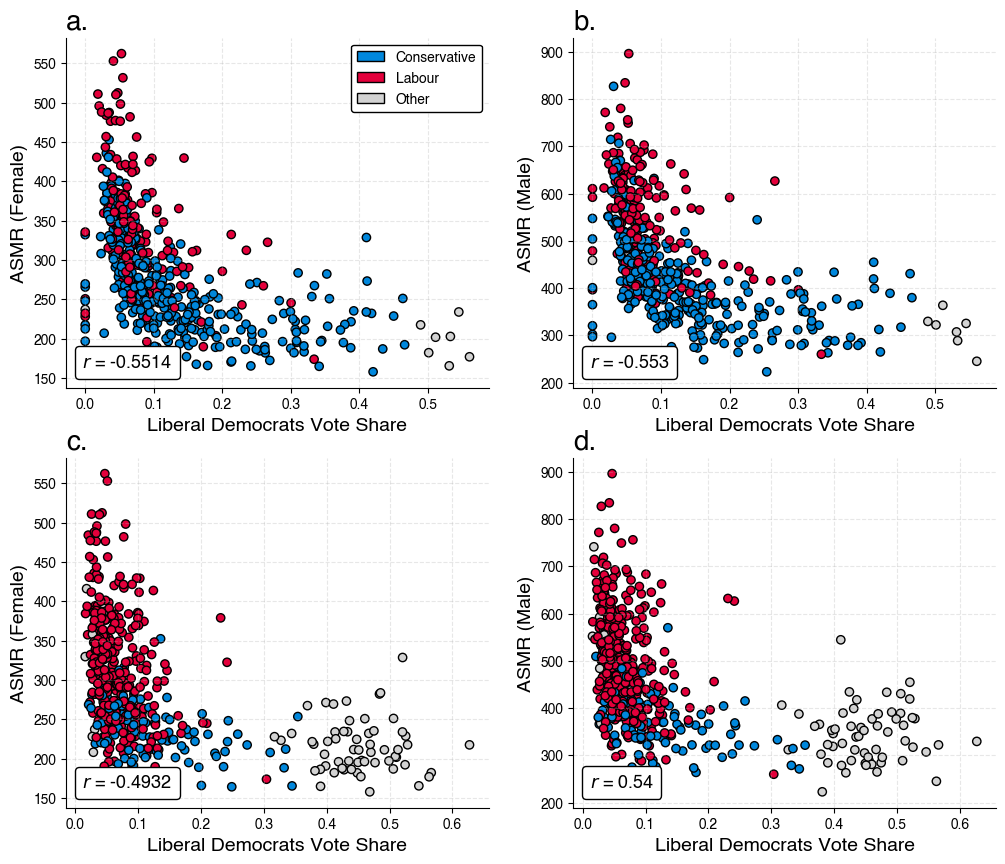

In [11]:
plot_scatters(df_2019, df_2024, ['Lib PC', 'Liberal Democrats', False])

The length of the 2019 data going into the scatters is:  532
The length of the 2024 data going into the scatters is:  518
2019: Electorate Voting Labour vote share vs ASMR (F) pearsons r: -0.7764, p-value 2.5299150527022383e-108
2024: Electorate Voting vote share vs ASMR (F) pearsons r: -0.801, p-value 4.787563994404367e-117
2019: Electorate Voting vote share vs ASMR (M) pearsons r: -0.791, p-value 4.168438711241148e-115
2024: Electorate Voting vote share vs ASMR (M) pearsons r: 0.54, p-value 1.3976802734757177e-40


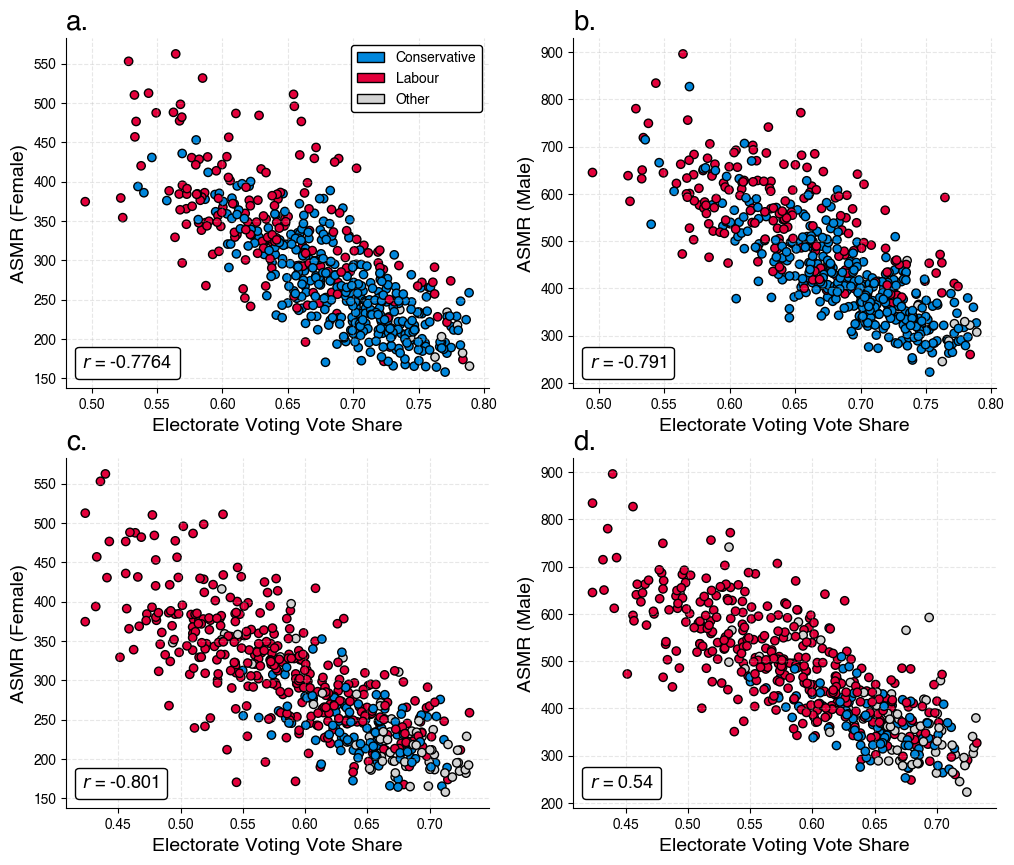

In [12]:
plot_scatters(df_2019, df_2024, ['Vote PC', 'Electorate Voting', False])

### Section 2: 2021 Census data analysis

#### Section 2.1: Loading the data.

Before we move on to creating the bivariate chorpleths, we should give full and unreserved thanks to [Suzuki Shosuke](https://github.com/shosuke-13/Japan-Bivariate-Choroplethmaps) for their insipirational code which helps us to do something that is not trivially easy in Python. Great job and many thanks, Suzuki!
ole 5

Note here, that our census data for 2021 can be re-drawn at either of the constituency levels from the ONS portal. This means we can get -- in theory -- the whole 533 and 543 constituencies in our analysis (until we latterly drop the peaker).

To work towards plotting the choropleth maps, we need to load our shapefile and merge geometry into our regular pandas dataframe (to make it a geopandas dataframe, with 'geometry' as the series of interest):

In [14]:
df_gpd_2019 = make_df_gpd_census(2019)
df_gpd_2024 = make_df_gpd_census(2024)

Filter the dataframes to just have english data in:

In [15]:
df_gpd_2019 = df_gpd_2019[df_gpd_2019['Country name']== 'England']
df_gpd_2024 = df_gpd_2024[df_gpd_2024['Country name']== 'England']

Note: we need the speaker for the minute, although, here, because we arent reporting any correlations, it isnt egregious to do so. Lets check therefore that we have 533 and 534 rows in our new geopandas dataframes (which have got shapefile polygons within them to make the maps):

In [16]:
print('Lenth of pandas gpd in 2019: ', len(df_gpd_2019))
print('Lenth of pandas gpd in 2024: ', len(df_gpd_2024))

Lenth of pandas gpd in 2019:  533
Lenth of pandas gpd in 2024:  543


#### Section 2.2: Visualise the data across various parties.

Plot the bivariate chorpleths for the census data. note that this gets saved out to .data/derived so that we can check the ranks all work (and the speakers rank is the lowest for all parties!). This allows us to check that the specific ranks align to the order of the raw census and voting data. Note that the health score is defined as people in the proportion of bad health, and the disability metric is proportion disabled in the same style three-category code. The ranks corresponding go from low to high for all: e.g. low rank is low vote, low health problems, low disabilities.

Lets do this for three countries, starting with Labour:

In [ ]:
plot_bivariate_choropleth_map_census(df_gpd_2019,
                                     df_gpd_2024,
                                     ['Lab', 'Labour'])

In [ ]:
plot_bivariate_choropleth_map_census(df_gpd_2019,
                                     df_gpd_2024,
                                     ['Con', 'Cons'])

In [ ]:
plot_bivariate_choropleth_map_census(df_gpd_2019,
                                     df_gpd_2024,
                                     ['Lib', 'Lib Dems'])

Length of the 2019 dataset going into this:  533
Length of the 2024 dataset going into this:  543


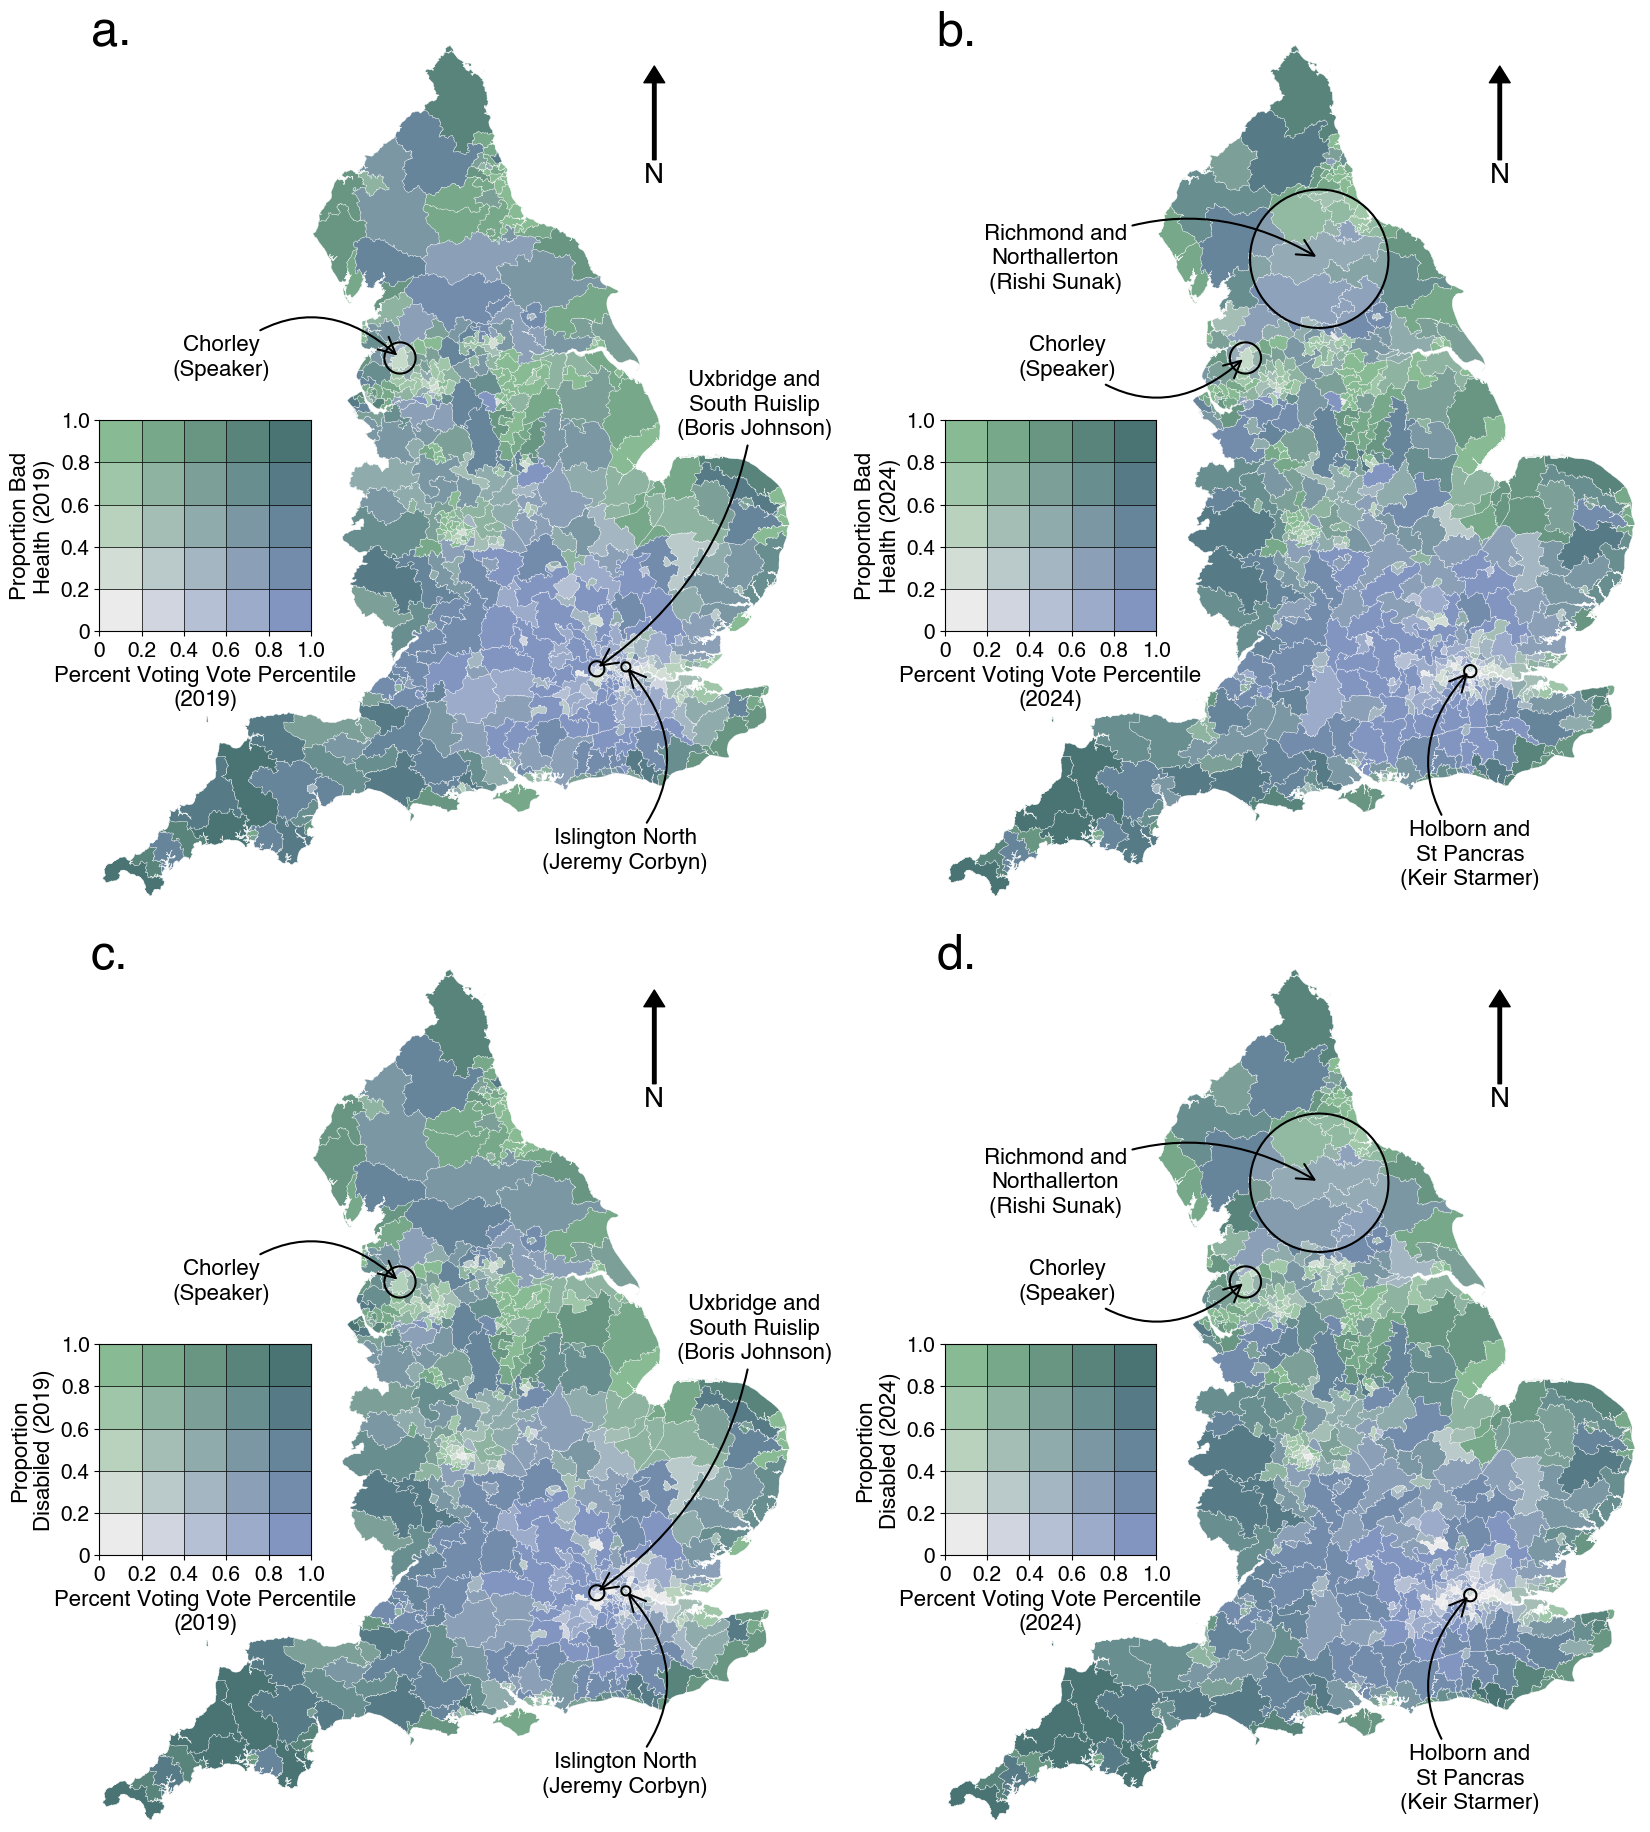

In [17]:
plot_bivariate_choropleth_map_census(df_gpd_2019,
                                     df_gpd_2024,
                                     ['Vote', 'Percent Voting'])

Now, lets drop the speaker (we need them for the maps above) to get the nice annotations, but they need to drop out of the correlational analysis because they have zero votes (not a NaN per-se, but an observation which shouldn't be included):

In [ ]:
df_gpd_2019 = df_gpd_2019[df_gpd_2019['First party']!='Spk']
df_gpd_2024 = df_gpd_2024[df_gpd_2024['First party']!='Spk']

Lets now create a table that we can use to look up rho and p-values to do with these spearman correlations for reporting:

In [ ]:
table_rho_2019, table_p_2019 = make_summary_tables(df_2019, df_gpd_2019, '2019')
table_rho_2024, table_p_2024 = make_summary_tables(df_2024, df_gpd_2024, '2024')

We make separate function calls because Brx PC and RUKPC are different.

In [ ]:
table_rho_2019, table_p_2019 = make_summary_tables(df_2019, df_gpd_2019, '2019')
table_rho_2024, table_p_2024 = make_summary_tables(df_2024, df_gpd_2024, '2024')

Lets print out the results for the year 2019:

In [ ]:
print(table_rho_2019.to_markdown())

Lets print out the results for the 2024 year:

In [ ]:
print(table_rho_2024.to_markdown())

### Section 3: What are the patterns in this over time?

What are the patterns like over time at a national level? First load in some data from the ONS on the [PHOF_Slope_Index_of_Inequality](https://fingertips.phe.org.uk/documents/PHOF_Slope_Index_of_Inequality_Method.pdf), followed by [data](https://analytics.phe.gov.uk/apps/health-inequalities-dashboard/) from the Office for Health Improvement and Disparities:

In [ ]:
df_sii = make_sii()
df_hid = make_hid()

Then, lets make a couple of plots over time. The first is our SII metric for male and females (subfigure 'a.'), and the second and third subfigures look at Male and Female Health Life Expectancy at Birth at the 1st, 5th, and 10th decile of deprivation.

In [ ]:
plot_over_time(df_sii, df_hid)

Finally, lets get a few scalars about these changes in case we want to use them:

In [ ]:
make_temporal_printouts(df_sii, df_hid)